In [1]:
import cudasift
import cv2
import timeit
import time

In [2]:
import matplotlib.pyplot as plt

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
%matplotlib notebook

In [4]:
# import the necessary packages
import numpy as np
import urllib
import cv2
 
# METHOD #1: OpenCV, NumPy, and urllib
def url_to_image(url):
	# download the image, convert it to a NumPy array, and then read
	# it into OpenCV format
	resp = urllib.urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
 
	# return the image
	return image

In [32]:
defaultargs={
    'low_pix':10.0,
    'high_pix':99.8,
    'contrast_adjust':1,
    'clahe_size':90,
    'clahe_clip_limit':1.5,
    'sigma':4,
    'fill_with_noise':True
}
def filter_em_image(img,args=defaultargs):

    
    mask=np.array(img>0,np.uint8)
    #img = 255-img
    #f, ax = plt.subplots(1,1,figsize=(10,10))
    #ax.imshow(img,cmap=plt.cm.gray)
    low_pix = args['low_pix']/100
    high_pix = args['high_pix']/100
    hgram=cv2.calcHist([img],[0],mask,[256],[0,256])
    cum_dist = np.cumsum(hgram)/np.sum(hgram)
    min_level = np.where(np.diff(cum_dist>low_pix)==1)[0][0]
    max_level = np.where(np.diff(cum_dist<high_pix)==1)[0][0]

    img = np.array(img,np.double)
    print 'min_level',min_level
    print 'max_level',max_level
    if (max_level==min_level):
        print 'min_level',min_level
        print 'max_level',max_level
        print 'on file',path_in
        raise Exception("%s %f %f"%(path_in,min_level,max_level))

    img = ((img-min_level)/(max_level-min_level))*255
    #img = (img - 128)*args['contrast_adjust'] + 128
    #print 'img[2012,195]',img[2012,195]
    img = np.clip(img,0,255)
    #print 'img[2012,195]',img[2012,195]
    img = np.array(img,np.uint8)
    #print 'img[2012,195]',img[2012,195]
    img = cv2.GaussianBlur(img,(2*args['sigma']+1,2*args['sigma']+1),args['sigma'],args['sigma'])
    #img = cv2.bilateralFilter(img,5,20,20)
    #clahe1 = cv2.createCLAHE(clipLimit=.5, tileGridSize=(10,10))
    #grid_size = args['clahe_size']
    #clahe2 = cv2.createCLAHE(clipLimit=args['clahe_clip_limit'],
    #    tileGridSize=(grid_size,grid_size))
    #img = clahe1.apply(img)
    #img = clahe2.apply(img)
    if args['fill_with_noise']:
        noise = np.random.randint(0,255+1,img.shape,dtype=img.dtype)
        noise*=(1-mask)
        img+=noise
    return img

In [33]:
#img = url_to_image('http://github.com/Celebrandil/CudaSift/blob/Maxwell/data/img1.png?raw=true')
# img = np.zeros((100, 100), np.uint8)
# img[10:-9, 10] = 128
# img[10, 10:-9] = 128
# img[10:-9, -10] = 128
# img[-10, 10:-9] = 128
img1 = cv2.imread('image1.tif',0)
img2 = cv2.imread('image2.tif',0)
#img1 = img1[0:1024,1024:]
#img2 = img2[1024:,0:1024]
#img1 = cv2.resize(img1,(img1.shape[0]/4,img1.shape[1]/4))
#img2 = cv2.resize(img2,(img2.shape[0]/4,img2.shape[1]/4))
img1 = filter_em_image(img1)
img2 = filter_em_image(img2)


min_level 60
max_level 133
min_level 58
max_level 134


<IPython.core.display.Javascript object>


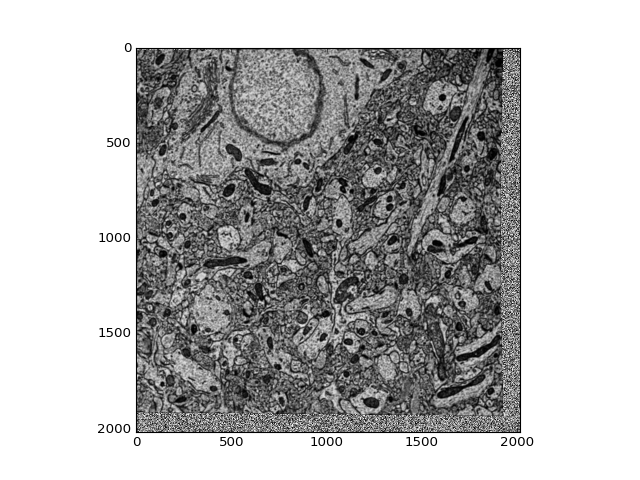

<IPython.core.display.Javascript object>


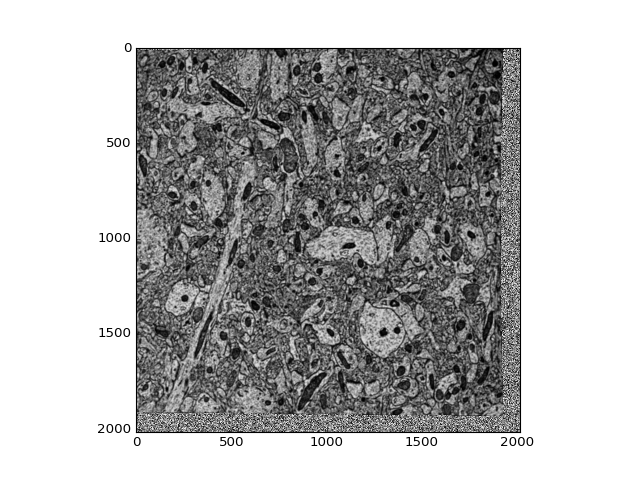

In [34]:
plt.figure()
plt.imshow(img1,cmap=plt.cm.gray,vmin=0,vmax=255)
plt.figure()
plt.imshow(img2,cmap=plt.cm.gray,vmin=0,vmax=255)

In [90]:
def get_sift_points(img,minscale=7,maxpoints=30000):
    #img=filter_em_image(img)
    pysift= cudasift.PySiftData(maxpoints)
    cudasift.ExtractKeypoints(img,pysift,thresh=3,initBlur=1.0)
    df,A=pysift.to_data_frame()
    good = (df.scale>minscale)
    pysift2=cudasift.PySiftData.from_data_frame(df[good],A[np.where(good)[0],:])
    return pysift2

In [91]:
now=timeit.time.time()
pys1 = get_sift_points(img1)
pys2 = get_sift_points(img2)
cudasift.PyMatchSiftData(pys1,pys2)
print timeit.time.time()-now

0.167858123779


In [92]:
df1,a1=pys1.to_data_frame()
df2,b1=pys2.to_data_frame()


<IPython.core.display.Javascript object>


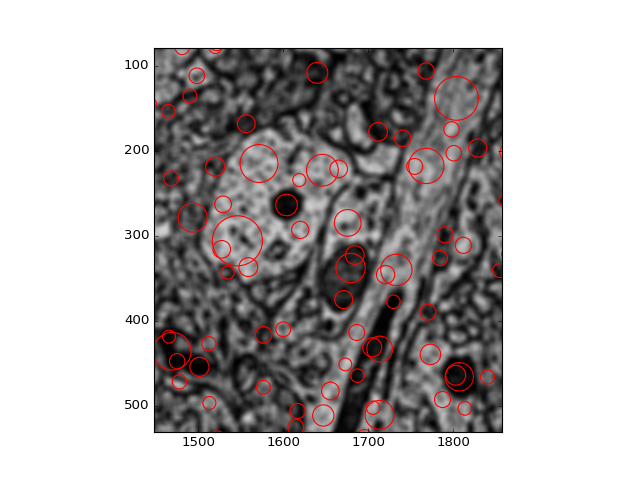

<IPython.core.display.Javascript object>


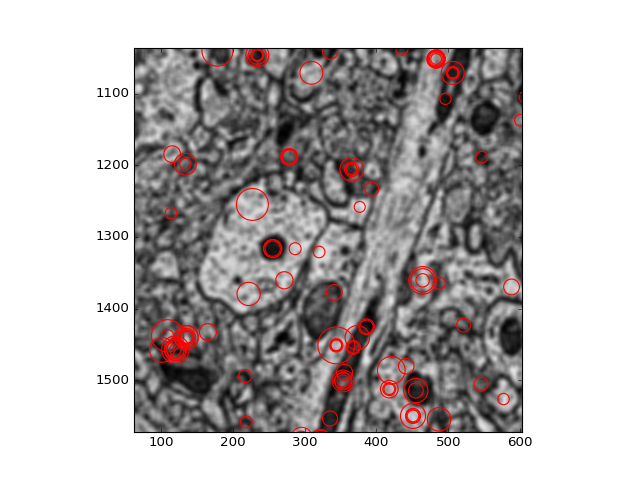

In [93]:
def plot_keypoints(img,df):
    f,ax = plt.subplots(1,1)

    
    ax.imshow(img,cmap=plt.cm.gray)

    for i,row in df.iterrows():
        circle = plt.Circle((row.xpos,row.ypos),row.scale,fill=False,edgecolor='r')
        ax.add_patch(circle)
def plot_match_keypoints(img,df):
    f,ax = plt.subplots(1,1)

    ax.imshow(img,cmap=plt.cm.gray)

    for i,row in df.iterrows():
        circle = plt.Circle((row.match_xpos,row.match_ypos),row.scale,fill=False,edgecolor='r')
        ax.add_patch(circle)
    #df1sub.plot(kind='scatter',x='xpos',y='ypos',s=df1.scale*20,norm=None,ax=ax)
plot_keypoints(img1,df1[df1.score>.8])
plot_match_keypoints(img2,df1[df1.score>.8])

In [43]:
def draw_matches(img1, df1, img2, color=None,thickness=2): 
    """Draws lines between matching keypoints of two images.  
    Keypoints not in a matching pair are not drawn.

    Places the images side by side in a new image and draws circles 
    around each keypoint, with line segments connecting matching pairs.
    You can tweak the r, thickness, and figsize values as needed.

    Args:
        img1: An openCV image ndarray in a grayscale or color format.
        kp1: A cudasift dataframe of keypoints from img1 to img2.
        img2: An openCV image ndarray of the same format and with the same 
        element type as img1.  
        A 3-tuple for color images, a scalar for grayscale images.  If None, these
        values are randomly generated.  
    """
    # We're drawing them side by side.  Get dimensions accordingly.
    # Handle both color and grayscale images.
    f,ax = plt.subplots(1,1,figsize=(10,5))

    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))  

    # Place images onto the new image.
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    ax.imshow(new_img,cmap=plt.cm.gray)
    # Draw lines between matches.  Make sure to offset kp coords in second image appropriately.
    r = 15
    if color:
        c = color
    for i,row in df1.iterrows():
        # Generate random color for RGB/BGR and grayscale images as needed.
        if not color: 
            c = np.random.randint(0,256,3) if len(img1.shape) == 3 else np.random.randint(0,256)
        # So the keypoint locs are stored as a tuple of floats.  cv2.line(), like most other things,
        # wants locs as a tuple of ints.
        end1 = [row.xpos,row.ypos]
        end2 = [row.match_xpos+img1.shape[1],row.match_ypos]
        ax.plot([end1[0],end2[0]],[end1[1],end2[1]],linewidth= thickness)
        #cv2.circle(new_img, end1, r, c, thickness)
        #cv2.circle(new_img, end2, r, c, thickness)
    ax.set_xlim(0,img1.shape[1]+img2.shape[1])
    ax.set_ylim(max(img1.shape[0],img2.shape[0]),0)


<IPython.core.display.Javascript object>


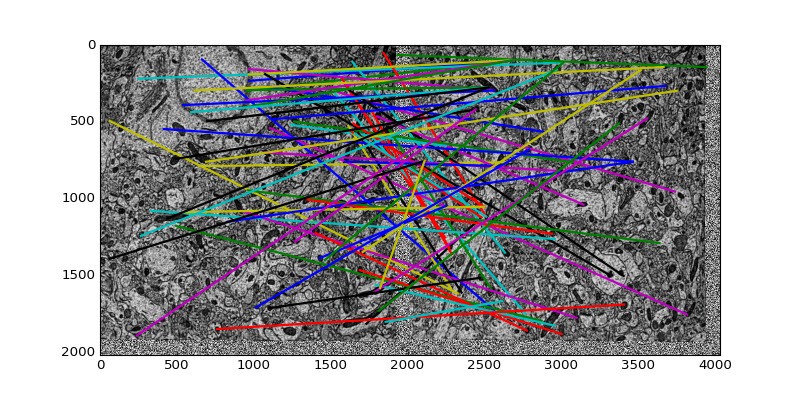

In [79]:
draw_matches(img1,df1[df1.score>.87],img2)

In [88]:
import ransac
def find_model(df,N=3000): 
    p1 = np.array(df[['xpos','ypos']])
    p2 = np.array(df[['match_xpos','match_ypos']])

    transModel=ransac.AffineModel()
    bestModel,bestInlierIdx=ransac.ransac(p1,p2,transModel,3,N,20.0,4,debug=True,return_all=False)
    return bestModel,bestInlierIdx

In [89]:
now=timeit.time.time()
dffilt = df1[df1.score>.87]
print dffilt.shape
model,inlierIdx = find_model(dffilt,N=dffilt.shape[0]*dffilt.shape[0])
#draw_matches(img1,dffilt.iloc[inlierIdx,:],img2)
print timeit.time.time()-now

(68, 13)
0.993309020996


<IPython.core.display.Javascript object>


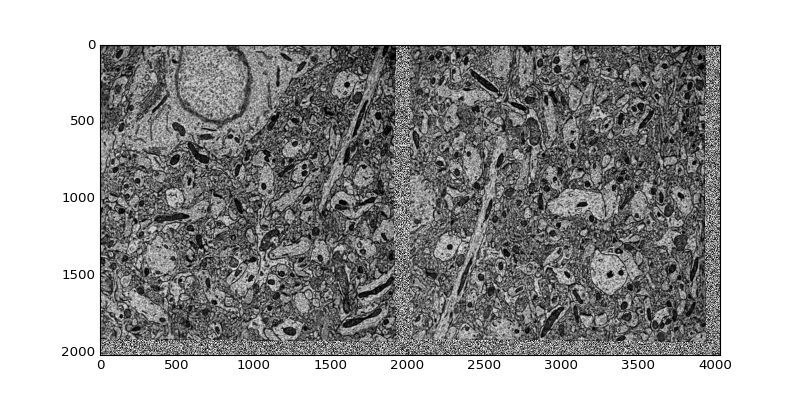

In [76]:
draw_matches(img1,dffilt.iloc[inlierIdx,:],img2)